# ImagineUI RAG Evaluation

This notebook evaluates the RAG system's ability to match user design requirements with appropriate examples.

Since many pre-built evaluators are built to evaluate question-answer pairs, we're going to need a custom evaluator that can score how well the provided designs match the user's intention.

This evaluator will analyze the responses based on five criteria:

1. Visual Style Match (0-10): How well does the design's visual style align with what was requested?
2. Layout Requirements (0-10): How well does the design's layout meet the specified needs?
3. Color & Mood (0-10): How well do the colors and overall mood match the requirements?
4. Specific Features (0-10): How well does the design include specifically requested features?
5. Overall Match (0-10): Overall, how well does this design satisfy the user's needs?

The overall scores are then averaged to assess the application's performance.

In [9]:
from langchain.evaluation import StringEvaluator
from langchain_openai import ChatOpenAI
from langchain.smith import RunEvalConfig
from typing import Dict, Any
import json

class DesignMatchEvaluator(StringEvaluator):
    """Evaluates how well a retrieved design matches the user's requirements."""
    
    def __init__(self):
        self.llm = ChatOpenAI(model="gpt-4", temperature=0)
    
    def _evaluate_strings(
        self, prediction: str, reference: str, input: str, **kwargs
    ) -> Dict[str, Any]:
        """Synchronous evaluation - required by StringEvaluator"""
        raise NotImplementedError(
            "This evaluator only supports async evaluation. Use aevaluate_strings instead."
        )
    
    async def aevaluate_strings(
        self, prediction: str, reference: str, input: str, **kwargs
    ) -> Dict[str, Any]:
        """Evaluate the match between user requirements and retrieved design."""
        
        # Fix the JSON template in the prompt
        prompt = f"""You are evaluating a design recommendation system.
        
        USER REQUIREMENTS:
        {input}
        
        RECOMMENDED DESIGN:
        {prediction}
        
        Score how well the recommended design matches the user's requirements in these categories:
        1. Visual Style Match (0-10): How well does the design's visual style align with what was requested?
        2. Layout Requirements (0-10): How well does the design's layout meet the specified needs?
        3. Color & Mood (0-10): How well do the colors and overall mood match the requirements?
        4. Specific Features (0-10): How well does the design include specifically requested features?
        5. Overall Match (0-10): Overall, how well does this design satisfy the user's needs?
        
        Provide scores and brief explanations in JSON format exactly like this:
        {{
            "visual_style": {{"score": 7, "reason": "The design aligns with..."}},
            "layout": {{"score": 8, "reason": "The layout provides..."}},
            "color_mood": {{"score": 6, "reason": "The colors match..."}},
            "features": {{"score": 7, "reason": "The design includes..."}},
            "overall": {{"score": 7, "reason": "Overall, this design..."}}
        }}
        
        Return only valid JSON, nothing else.
        """
        
        response = await self.llm.ainvoke(prompt)
        try:
            scores = json.loads(response.content)
            # Calculate normalized score (0-1)
            normalized_score = scores["overall"]["score"] / 10.0
            return {
                "score": normalized_score,
                "visual_style_score": scores["visual_style"]["score"] / 10.0,
                "layout_score": scores["layout"]["score"] / 10.0,
                "color_mood_score": scores["color_mood"]["score"] / 10.0,
                "features_score": scores["features"]["score"] / 10.0,
                "reasoning": scores
            }
        except Exception as e:
            print(f"Error parsing evaluation response: {e}")
            print(f"Response content: {response.content}")
            return {"score": 0, "error": str(e)}

In [8]:
# Create test dataset
test_queries = [
    "I need a minimalist design with lots of whitespace, using a monochromatic color scheme",
    "Looking for a playful, colorful design with rounded elements and a friendly feel",
    "Need a professional business design with a dark theme and sharp angles",
    "Want a nature-inspired design with organic shapes and earthy colors",
    "Looking for a tech-focused design with a futuristic feel and neon accents",
    "I want the craziest design you can find!",
    "I'd like an eye-catching design for a small business with some quirky personality. Make us stand out from the crowd!",
    "I want something clinical and informative. It should focus on clear presentation of information and reader usability."
]

# Initialize evaluator
evaluator = DesignMatchEvaluator()

# Configure evaluation
eval_config = RunEvalConfig(
    evaluators=[evaluator]
)

Loaded 141 design documents
Created dataset: design_evaluation_1740511422
Evaluating query 1/5: I need a minimalist design with lots of whitespace...
Generated query: minimalist design whitespace monochromatic color scheme aesthetic clean simple modern design category theme key visual characteristics visual impact desired specific preferences constraints minimalistic design whitespace monochromatic color scheme.
  LangSmith error: 'NoneType' object has no attribute 'id'
  Score: 0.90
Evaluating query 2/5: Looking for a playful, colorful design with rounde...
Generated query: playful colorful design rounded elements friendly feel
  LangSmith error: 'NoneType' object has no attribute 'id'
  Score: 0.80
Evaluating query 3/5: Need a professional business design with a dark th...
Generated query: "professional business design dark theme sharp angles"
  LangSmith error: 'NoneType' object has no attribute 'id'
  Score: 0.80
Evaluating query 4/5: Want a nature-inspired design with organic shap

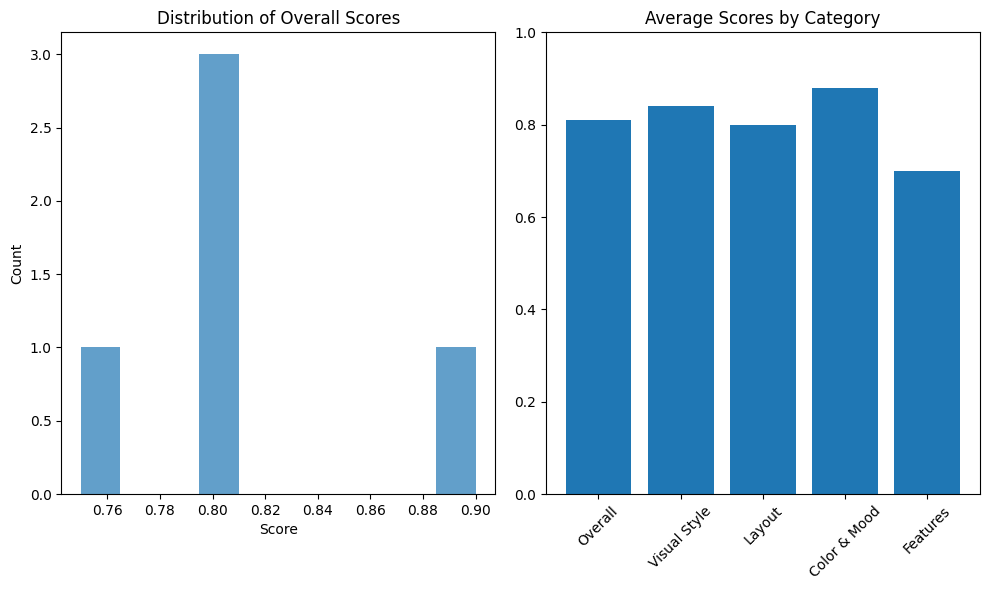

,query,score,reasoning
0,I need a minimalist design with lots of whites...,0.90,"{'visual_style': {'score': 9, 'reason': 'The d..."
1,"Looking for a playful, colorful design with ro...",0.80,"{'visual_style': {'score': 8, 'reason': 'The d..."
2,Need a professional business design with a dar...,0.80,"{'visual_style': {'score': 8, 'reason': 'The d..."
3,Want a nature-inspired design with organic sha...,0.75,"{'visual_style': {'score': 8, 'reason': 'The d..."
4,Looking for a tech-focused design with a futur...,0.80,"{'visual_style': {'score': 9, 'reason': 'The d..."



View detailed results in LangSmith:
https://smith.langchain.com/projects/imagineui


In [7]:
# Run evaluation using correct LangSmith API
from chains.design_rag import DesignRAG
import asyncio
from langsmith import Client
import uuid
import json

# Extract design IDs from the responses
def extract_design_id(response):
    """Extract the design ID from the response URL"""
    try:
        # Find the URL line in the response
        if isinstance(response, str) and "URL:" in response:
            url_line = [line for line in response.split('\n') if "URL:" in line][0]
            # Extract the ID from the URL
            return url_line.split('/')[-1]
        return "unknown"
    except Exception:
        return "unknown"

async def evaluate_rag():
    # Create LangSmith client
    client = Client()
    
    # Initialize the RAG system
    rag = DesignRAG()
    results = []
    
    # Create a unique dataset name using a timestamp
    import time
    timestamp = int(time.time())
    dataset_name = f"design_evaluation_{timestamp}"
    
    # Create dataset in LangSmith - API has changed, no longer accepts examples directly
    try:
        dataset = client.create_dataset(
            dataset_name=dataset_name,
            description="Design RAG system evaluation"
        )
        print(f"Created dataset: {dataset_name}")
        
        # Now add examples to the dataset
        for query in test_queries:
            client.create_example(
                dataset_id=dataset.id,
                inputs={"query": query},
                outputs={}  # No outputs yet
            )
    except Exception as e:
        print(f"Error with dataset: {e}")
        # Continue without dataset
    
    # Now evaluate each query
    for i, query in enumerate(test_queries):
        print(f"Evaluating query {i+1}/{len(test_queries)}: {query[:50]}...")
        
        try:
            # Execute the query without LangSmith integration first
            response = await rag.query_similar_designs([query])
            
            # Evaluate response
            eval_result = await evaluator.aevaluate_strings(
                prediction=response,
                reference="",  # No ground truth in RAG
                input=query
            )
            
            # Manual logging to LangSmith - simpler approach
            try:
                # Create a run with the required run_type parameter
                run = client.create_run(
                    project_name="imagineui",
                    run_type="chain",  # Required parameter
                    name=f"design_query_{i}",
                    inputs={"query": query},
                    outputs={"response": response}
                )
                
                # Add evaluation as feedback
                client.create_feedback(
                    run_id=run.id,
                    key="design_match",
                    score=eval_result.get("score", 0),
                    comment=json.dumps(eval_result.get("reasoning", {}))
                )
                
                run_id = run.id
            except Exception as e:
                print(f"  LangSmith error: {e}")
                run_id = "error"
            
            # Add to our local results
            results.append({
                "query": query,
                "response": response,
                **eval_result,
                "run_id": run_id
            })
            
            print(f"  Score: {eval_result.get('score', 0):.2f}")
            
        except Exception as e:
            print(f"Error evaluating query {i}: {str(e)}")
            results.append({
                "query": query,
                "error": str(e)
            })
    
    # Save results locally as a backup
    try:
        import pandas as pd
        results_df = pd.DataFrame(results)
        results_df.to_csv(f"evaluation_results_{timestamp}.csv", index=False)
        print(f"Saved results to evaluation_results_{timestamp}.csv")
    except Exception as e:
        print(f"Error saving results: {e}")
    
    return results

# Run the evaluation
results = await evaluate_rag()

# Display results
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(results)

#grab the design id from the response
if 'response' in df.columns:
    df['design_id'] = df['response'].apply(extract_design_id)

# Check if we have score data
if 'score' in df.columns and not df['score'].isnull().all():
    # Calculate average scores
    print("\n--- EVALUATION SUMMARY ---")
    print(f"Number of queries evaluated: {len(df)}")
    print("\nAverage Scores:")
    print(f"Overall: {df['score'].mean():.2f}")
    print(f"Visual Style: {df['visual_style_score'].mean():.2f}")
    print(f"Layout: {df['layout_score'].mean():.2f}")
    print(f"Color & Mood: {df['color_mood_score'].mean():.2f}")
    print(f"Features: {df['features_score'].mean():.2f}")

    # Create a summary visualization
    plt.figure(figsize=(10, 6))

    # Score distribution
    plt.subplot(1, 2, 1)
    plt.hist(df['score'], bins=10, alpha=0.7)
    plt.title('Distribution of Overall Scores')
    plt.xlabel('Score')
    plt.ylabel('Count')

    # Category comparison
    plt.subplot(1, 2, 2)
    categories = ['Overall', 'Visual Style', 'Layout', 'Color & Mood', 'Features']
    scores = [
        df['score'].mean(), 
        df['visual_style_score'].mean(), 
        df['layout_score'].mean(),
        df['color_mood_score'].mean(), 
        df['features_score'].mean()
    ]

    plt.bar(categories, scores)
    plt.title('Average Scores by Category')
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Show detailed results
    display(df[['query', 'score', 'design_id', 'reasoning']])
else:
    # Show error information
    print("Evaluation failed to produce scores. See errors:")
    display(df[['query', 'error'] if 'error' in df.columns else ['query']])

# Print URL to view results in LangSmith
print("\nView detailed results in LangSmith:")
print("https://smith.langchain.com/projects/imagineui")